# **Modelo v1 | GRU/LSTM - Classificação de texto do usuário**

## **Link do Projeto no Colab**
---

https://colab.research.google.com/drive/18-NQJNCbYPK1YfvLq9KDVs2u39h4pkqq?usp=sharing

## **Introdução**
---

A classificação de texto é uma tarefa fundamental no processamento de linguagem natural, que visa categorizar automaticamente documentos de texto em diferentes classes ou categorias. Essa técnica permite extrair insights valiosos de grandes volumes de dados não estruturados, como sentimentos, tópicos ou intenções expressas nos textos. Com o avanço das tecnologias de aprendizado de máquina e a disponibilidade de conjuntos de dados cada vez mais robustos, a classificação de texto tornou-se uma ferramenta poderosa para a análise e organização de informações, encontrando aplicações em áreas como análise de sentimentos, filtragem de spam, detecção de notícias falsas e muito mais.

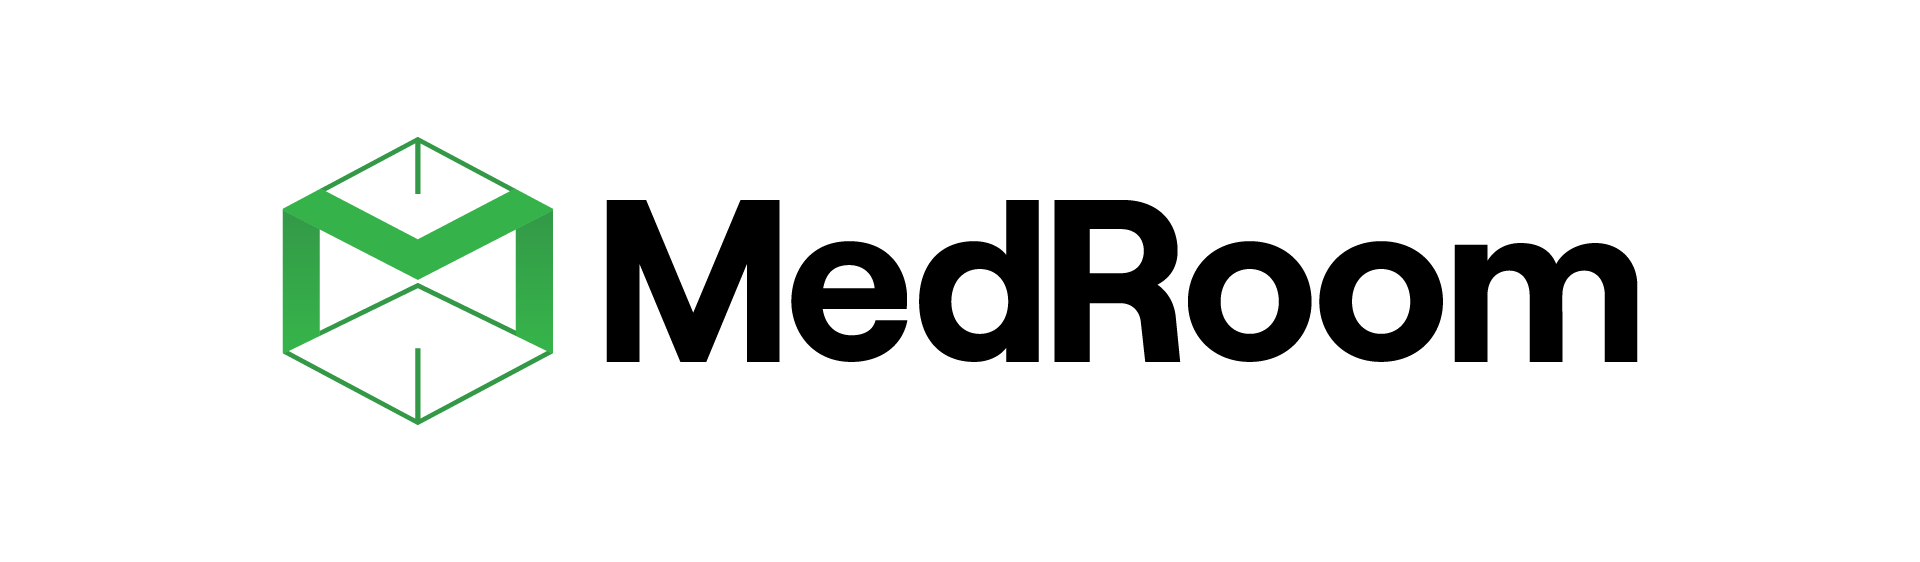

Neste projeto, faremos uso de um conjunto de dados pré-processados composto por interações de usuários com o paciente virtual Simplício, essas interações foram rotuladas pelo ChatGPT com as seguintes classes: Boas-vindas, Comando, Investigação, Orientação e Término da consulta. Empregaremos técnicas de pré-processamento de texto e treinaremos um modelo de classificação de texto utilizando uma arquitetura de redes neurais chamada GRU e LSTM.

## **Sobre os dados**
---

Neste estudo, estaremos utilizando dados obtidos de diálogos entre pessoas reais e nosso modelo de inteligência artificial (Simplício) + Rotulagem feita pelo ChatGPT.

Tudo foi compilado em um único arquivo e no final temos duas colunas:
- **x_treino:** Texto do usuário/pessoas reais
- **y_treino:** Classe rotulada pelo ChatGPT

## **Objetivo**
---

Com base nas informações dispostas nesse conjunto de dados, temos como objetivo:
- Criar um modelo de classificação de texto das interações dos usuários

<img src="https://media.giphy.com/media/dQpUkK59l5Imxsh8jN/giphy.gif" alt="win" width="600"/>

## **Preparação dos dados**
---

### **Libs**
---

Primeiro, vamos importar as bibliotecas necessárias:

In [ ]:
import warnings # Ignorar avisos
warnings.filterwarnings('ignore')
import pandas as pd # Manipulação de dados
import numpy as np # Manipulação de arrays
import seaborn as sns # Gráficos
import matplotlib.pyplot as plt # Gráficos
%matplotlib inline
import nltk
from nltk.corpus import stopwords # Remoção de palavras irrelevantes
nltk.download('stopwords')
!pip install unidecode
from unidecode import unidecode # Remover acentos
import string # Manipulação de strings
from keras.wrappers.scikit_learn import KerasClassifier # Wrapper do Keras para uso com o Scikit-Learn
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score # Métricas de avaliação
from sklearn.model_selection import train_test_split # Divisão treino e teste
from sklearn.preprocessing import LabelEncoder # Preprocessamento
from sklearn import preprocessing # Pré-processamento de dados
!pip install tensorflow # Instalar TensorFlow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer # Tokenização
from tensorflow.keras.preprocessing.sequence import pad_sequences # Sequência de preenchimento
from tensorflow.keras.models import Sequential # Modelo sequencial
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Bidirectional, LSTM # Camadas do modelo
from tensorflow.keras.callbacks import EarlyStopping # Parada antecipada

### **DataFrame**
---

Em seguida, carregar o DataFrame com os dados:

In [2]:
# Importando dados
df = pd.read_excel('analise_exploratoria.xlsx')

In [3]:
# Visualizando as 10 primeiras linhas do df
df.head(10)

,Unnamed: 0,x_treino,y_treino
0,0,oi oi simples tudo bem,Boas-vindas
1,1,foi simples tudo bem,Boas-vindas
2,2,bom dia,Boas-vindas
3,3,oi simplicio como e que voce esta,Boas-vindas
4,4,oi querido esta tudo bem,Boas-vindas
5,5,qual o seu nome,Boas-vindas
6,6,qual o seu nome,Boas-vindas
7,7,qual e seu nome,Boas-vindas
8,8,bom dia simples tudo bem,Boas-vindas
9,9,bom dia simplicio,Boas-vindas


### **Limpeza e tratamento**
---

Antes de seguirmos com nosso estudo vamos criar uma função que remove pontuações, acentos e deixa as letras minúsculas.

In [4]:
# Criando função que vai tratar nosso texto
def tratar_texto(texto):
    # Remover acentos
    texto_sem_acentos = unidecode(texto)

    # Remover pontuações
    texto_sem_pontuacoes = texto_sem_acentos.translate(str.maketrans("", "", string.punctuation))

    # Converter para letras minúsculas
    texto_tratado = texto_sem_pontuacoes.lower()

    return texto_tratado

In [5]:
# Limpeza e tratamento de dados
df["x_treino"] = df.x_treino.apply(tratar_texto).astype(str)

# Remove linhas duplicadas
df = df.drop_duplicates()

In [6]:
# Verificando informações do dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  500 non-null    int64 
 1   x_treino    500 non-null    object
 2   y_treino    500 non-null    object
dtypes: int64(1), object(2)
memory usage: 15.6+ KB


### **LabelEncoder**
---

Feito a limpeza e tratamento de dados, vamos codificar os rótulos de classificação. A classe LabelEncoder é usada para transformar os rótulos de texto em valores numéricos. Isso é necessário para treinar o modelo de classificação:

In [7]:
# Pré-processamento dos dados
X = df['x_treino'].values
y = df['y_treino'].values

# Codificar os rótulos de sentimento
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

### **Divisão treino e teste**
---

Vamos dividir os dados em conjuntos de treino e teste. Neste exemplo, usaremos 80% dos dados para treino e 20% para teste:

In [8]:
# Divisão treino e teste
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    shuffle=True,
                                                    test_size=0.2,
                                                    random_state=1)

In [9]:
# Tamanho após divisão
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400,), (100,), (400,), (100,))

### **Tokenização e Sequenciamento**
---

Os textos são tokenizados (divididos em palavras ou subpalavras) usando a classe Tokenizer do Keras. Em seguida, as sequências de tokens são criadas usando o método texts_to_sequences. O comprimento máximo das sequências é definido como 50.

O sequenciamento dos textos é uma etapa importante no pré-processamento de dados em tarefas de processamento de linguagem natural, como a classificação de sentimentos. Ele envolve a representação textual em formato numérico, onde cada palavra é mapeada para um número inteiro.

In [10]:
# Tokenização e sequenciamento dos textos
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

max_len = 50  # Definir o comprimento máximo das sequências

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

## **Modelo GRU v1.0**
---

A Unidade Recorrente de Gated (GRU) é um tipo de camada recorrente utilizada em modelos de redes neurais para processar dados sequenciais, como texto, áudio e séries temporais. Ela é uma variação das redes neurais recorrentes (RNNs) que possui uma arquitetura simplificada, mas ainda capaz de capturar dependências de longo prazo nas sequências de dados. A GRU possui portões de atualização e reset que ajudam a controlar o fluxo de informações ao longo do tempo, permitindo a aprendizagem de representações ricas e contextualizadas. Sua simplicidade e eficácia tornam a GRU uma escolha popular em tarefas de processamento de linguagem natural, como tradução automática, resumo de texto e análise de sentimentos.

### **Construção da rede**
---

Primeiro vamos construir nosso modelo de rede neural:

O modelo inclui uma camada de embedding para representar palavras como vetores, camadas de dropout para evitar overfitting, uma camada GRU bidirecional para capturar informações contextuais e uma camada densa com ativação softmax para produzir probabilidades de classificação. O modelo é compilado com uma função de perda, otimizador e métricas apropriadas para classificação com várias classes.

In [13]:
'''Construção do modelo de rede neural GRU v1.0'''

# Criação do modelo sequencial
model = tf.keras.Sequential()

# Camada de embedding
model.add(tf.keras.layers.Embedding(vocab_size, 128, input_length=max_len))

# Camada de Dropout - Utilizado para zerar uma porcentagem dos neurônios, para evitar o overfiting (10%)
model.add(tf.keras.layers.Dropout(0.1))

# Camada GRU bidirecional
model.add(tf.keras.layers.Bidirectional(GRU(64)))

# Camada de Dropout - Utilizado para zerar uma porcentagem dos neurônios, para evitar o overfiting (10%)
model.add(tf.keras.layers.Dropout(0.1))

# Camada densa com função de ativação softmax (Porque temos um problema de classificação com mais de duas classes)
model.add(tf.keras.layers.Dense(5, activation='softmax'))

# Compilação do modelo com configurações de perda, otimizador e métricas
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
# Estrutura de como ficou nossa rede neural v1.0
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 128)           90112     
                                                                 
 dropout_2 (Dropout)         (None, 50, 128)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 165,253
Trainable params: 165,253
Non-trainable params: 0
________________________________________________

### **Callbacks**
---

Após a construção das redes, vamos estabelecer alguns callbacks:

Callbacks são funções usadas durante o treinamento de um modelo de rede neural para executar ações específicas em determinados eventos. Aqui está um resumo explicativo sobre cada um dos callbacks utilizados:

- **ModelCheckpoint**: Este callback é usado para salvar o melhor modelo durante o treinamento. O modelo é salvo em um arquivo específico ("best_model.h5") quando uma métrica monitorada, nesse caso "val_accuracy" (precisão de validação), é maximizada. A opção "save_best_only=True" garante que apenas o melhor modelo seja salvo.

- **ReduceLROnPlateau**: Esse callback reduz a taxa de aprendizado (learning rate) quando uma determinada métrica monitorada, aqui "val_accuracy", para de melhorar. A taxa de aprendizado é multiplicada por um fator (0.1) para diminuir sua velocidade. Isso ajuda a ajustar a aprendizagem do modelo e evitar que fique preso em mínimos locais.

- **EarlyStopping**: Esse callback permite interromper o treinamento antecipadamente com base em uma métrica monitorada. Aqui, se a "val_accuracy" não melhorar por um determinado número de épocas (patience=5), o treinamento é interrompido. A opção "restore_best_weights=True" restaura os pesos do modelo para aqueles obtidos na época em que a métrica era a melhor.

Esses callbacks ajudam a melhorar o desempenho e a eficiência do treinamento, permitindo que o modelo seja salvo, ajustando a taxa de aprendizado e evitando overfitting.

In [15]:
# Arquivo com melhor modelo v1.0
filepath = "best_model.h5"

# Salvando o melhor modelo
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
                                                monitor='val_accuracy',
                                                save_best_only=True,
                                                mode='max')
# Reduz a taxa de aprendizado
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy",
                                              factor=0.1,
                                              mode="max",
                                              min_lr=0.00001,
                                              patience=2)

# Parada antecipada para evitar overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,
                                                  monitor='val_accuracy',
                                                  mode = "max",
                                                  restore_best_weights=True)

### **Treinamento**
---

Feito isso, agora podemos treinar nosso modelo:

In [16]:
# Treinamento do modelo com dados de treinamento, número de épocas, tamanho do lote e uso dos callbacks
model.fit(X_train_pad, y_train,
          validation_data=(X_test_pad,y_test),
          epochs=100,
          batch_size=16,
          callbacks=[checkpoint,reduce_lr, early_stopping])

Epoch 1/100
25/25 [==============================] - 15s 214ms/step - loss: 1.5739 - accuracy: 0.3400 - val_loss: 1.5152 - val_accuracy: 0.6900 - lr: 0.0010
Epoch 2/100
25/25 [==============================] - 3s 117ms/step - loss: 1.3319 - accuracy: 0.7300 - val_loss: 1.0963 - val_accuracy: 0.7900 - lr: 0.0010
Epoch 3/100
25/25 [==============================] - 2s 94ms/step - loss: 0.7529 - accuracy: 0.8225 - val_loss: 0.6032 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 4/100
25/25 [==============================] - 1s 53ms/step - loss: 0.4047 - accuracy: 0.8825 - val_loss: 0.4248 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 5/100
25/25 [==============================] - 1s 45ms/step - loss: 0.2488 - accuracy: 0.9375 - val_loss: 0.3360 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 6/100
25/25 [==============================] - 0s 16ms/step - loss: 0.1543 - accuracy: 0.9625 - val_loss: 0.3025 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 7/100
25/25 [==============================] - 1s 28ms/step -

### **Avaliação | Dados de teste**
---

Agora que o modelo foi treinado, vamos avaliá-lo usando os dados de teste:

In [17]:
# Previsões
y_pred_prob = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_prob, axis=1)

4/4 [==============================] - 1s 6ms/step


In [19]:
# Mapeando rótulos numéricos de volta para seus valores originais
class_labels = ['Boas-vindas', 'Comando', 'Investigação', 'Orientação', 'Término da consulta']
y_test_labels = [class_labels[label] for label in y_test]
y_pred_labels = [class_labels[label] for label in y_pred]

#### **Acurácia**
---

Umas das métricas de avaliação é a "Acurácia", ela diz o quanto o modelo acertou de acordo com as previsões possíveis:

In [20]:
# Acurácia
acc = accuracy_score(y_test_labels, y_pred_labels)
print("Acurácia do modelo = %2.f%%" % (acc *100.00))

Acurácia do modelo = 92%


#### **ROC_AUC**
---

A métrica AUC-ROC (Area Under the Receiver Operating Characteristic Curve) é usada para avaliar o desempenho de modelos de classificação, especialmente em problemas binários ou multiclasse. A AUC-ROC mede a capacidade do modelo de distinguir entre diferentes classes, plotando a taxa de verdadeiros positivos (TPR) em relação à taxa de falsos positivos (FPR) para diferentes limiares de decisão.

Resumidamente, a AUC-ROC oferece as seguintes informações:

- Varia de 0 a 1: A AUC-ROC é uma métrica que varia de 0 a 1. Um valor de 0,5 indica um desempenho equivalente ao acaso, enquanto um valor próximo de 1 indica um modelo com alta capacidade de distinguir corretamente entre as classes.

- Representa a qualidade da classificação: Quanto maior a AUC-ROC, melhor o desempenho do modelo em classificar corretamente as amostras, principalmente em termos de sensibilidade (TPR) e especificidade (1 - FPR).

In [21]:
def roc_auc(y_test,y_pred):
  # Converter rótulos para formato binário
  lb = preprocessing.LabelBinarizer()
  lb.fit(y_test)

  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)

  # Calcular a área sob a curva (AUC-ROC)
  auc_roc = roc_auc_score(y_test, y_pred, average='weighted', multi_class='ovr')
  return print("ROC_AUC do modelo = %2.f%%" % (auc_roc *100.00))

In [22]:
# ROC-AUC
roc_auc(y_test_labels, y_pred_labels)

ROC_AUC do modelo = 95%


#### **Relatório de classificação**
---

Dentre as bibliotecas que importamos existe o "relatório de classificação", nele somos apresentados a mais 3 métricas, são elas:

- *Recall/Sensibilidade*: Medida que nos mostra o quão bom o modelo é para prever/detectar positivos
- *Precisão*: Medida que nos ajuda a responder a seguinte pergunta: Dos classificados como positivos, quantos são realmente positivos?
- *f1-score:* Nos mostra o balanço entre a precisão e o recall de nosso modelo, quanto mais próximo de 1 melhor

In [23]:
# Criando relatório de classificação
def relatorio(y_test,y_pred):
  report_df = pd.DataFrame(classification_report(y_test,y_pred, output_dict=True)). T
  report_df = report_df.drop(columns=['support'])

  # Plotagem do relatório de classificação
  plt.subplots(figsize=(4,3))
  sns.heatmap(report_df, cmap='Greens', linewidths=0.5, annot=True);

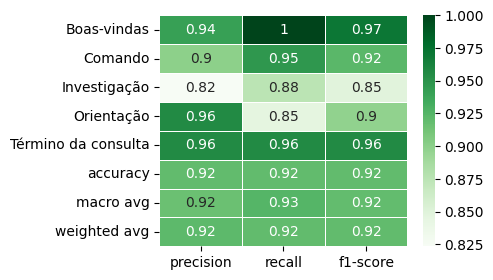

In [24]:
# Plot relatório de classificação
relatorio(y_test_labels, y_pred_labels)

#### **Matriz de confusão**
---

A "matriz de confusão" é uma tabela que mostra as frequências de classificação para cada classe do nosso modelo:

In [25]:
def matriz_confusao(y_test,y_pred):

  # Criando a matriz de confusão
  report_df = pd.DataFrame(classification_report(y_test,y_pred, output_dict=True)). T
  report_df = report_df.drop(columns=['support'])

  cnf_report_df = report_df.index[:-3]
  cnf_matrix = confusion_matrix(y_test,y_pred)
  cnf_matrix = pd.DataFrame(cnf_matrix, index = cnf_report_df.values, columns = cnf_report_df.values)
  cnf_matrix = cnf_matrix/cnf_matrix.sum(axis=1)[:, np.newaxis] # Normalização em linha (recall)

  # Plotagem da matriz de confusão
  sns.heatmap(cnf_matrix, cmap='Greens', linecolor='white', linewidths=0.5,
            annot=True, fmt='.0%', cbar=False, square=True);

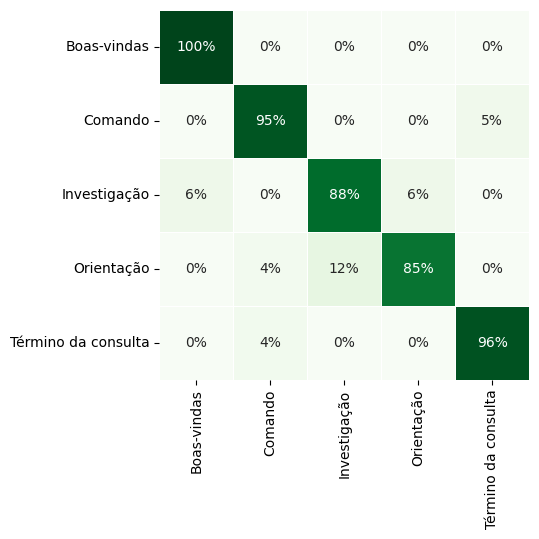

In [26]:
# Plot Matriz de confusão
matriz_confusao(y_test_labels, y_pred_labels)

#### **Resumo**
---

Conclusões após avaliação:
- Acurácia = 92%
- ROC_AUC = 95%
- F1-Score (média ponderada) ficou em 92%

Podemos dizer que tivemos um bom primeiro resultado. Em todas as classes tivemos uma assertividade superior à 80%, porém o modelo apresentou algumas confusões na classe 'Orientação' (85%) e 'Investigação' (88%).

#### **Análise de Overfiting**
---

O overfitting ocorre quando um modelo se ajusta muito bem aos dados de treinamento, mas tem dificuldade em generalizar para dados não vistos anteriormente, como os dados de teste. Vamos analisar como foi o desempenho no treinamento:

In [27]:
# Previsões
y_pred_prob_train = model.predict(X_train_pad)
y_pred_train = np.argmax(y_pred_prob_train, axis=1)

13/13 [==============================] - 0s 4ms/step


In [36]:
# Mapeando rótulos numéricos de volta para seus valores originais
class_labels = ['Boas-vindas', 'Comando', 'Investigação', 'Orientação', 'Término da consulta']
y_train_labels = [class_labels[label] for label in y_train]
y_pred_train_labels = [class_labels[label] for label in y_pred_train]

In [32]:
# Acurácia
acc = accuracy_score(y_train_labels, y_pred_train_labels)
print("Acurácia do modelo = %2.f%%" % (acc *100.00))

Acurácia do modelo = 99%


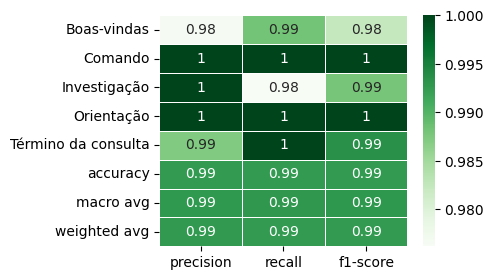

In [39]:
# Relatório de classificação
relatorio(y_train_labels, y_pred_train_labels)

Ao analisar os resultados do relatório de classificação, podemos observar que o desempenho do modelo nos dados de treinamento é quase perfeito, com quase todas as métricas (precisão, recall e F1-score) alcançando o valor máximo de 1.00. Isso indica que o modelo foi capaz de aprender muito bem os padrões presentes nos dados de treinamento.

A acurácia não ficou distante dos dados de teste, então até aqui o modelo não apresentou overfiting. Vamos confirmar após a avaliação com dados de validação.

### **Avaliação | Dados de validação**
---

#### **DataFrame**
---

Para nosso teste de validação, utilizei um [prompt](https://docs.google.com/document/d/1Z3OZtrtYm_S2ZLDuqDoIpkLTXqZ9irvDSRljhpwflfU/edit?usp=sharing) para gerar novas frases no chatGPT e inclui numa planilha:

In [40]:
# Importando os dados
df_val = pd.read_csv("Dados_validacao_comandos.csv")

In [41]:
# Visualizando as 10 primeiras linhas
df_val.head(10)

,Texto,Classificacao
0,"Olá, seja bem-vindo à consulta.",Boas-vindas
1,"Bom dia, é um prazer recebê-lo aqui.",Boas-vindas
2,"Seja muito bem-vindo, senhor.",Boas-vindas
3,"Oi, tudo bem? Sente-se, por favor.",Boas-vindas
4,"Boa tarde, fico feliz em vê-lo por aqui.",Boas-vindas
5,"Bem-vindo à sua consulta, senhor.",Boas-vindas
6,"Olá, Simplício, como posso ajudá-lo hoje?",Boas-vindas
7,"Seja bem-vindo à clínica, senhor.",Boas-vindas
8,"Bom dia, é um prazer tê-lo aqui conosco.",Boas-vindas
9,"Olá, senhor, sinta-se à vontade.",Boas-vindas


In [42]:
# Verificando informações
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Texto          100 non-null    object
 1   Classificacao  100 non-null    object
dtypes: object(2)
memory usage: 1.7+ KB


Temos 100 frases de validação, sendo 20 para cada classificação.

Vamos aplicar o pré-processamento necessário e depois nossas previsões no dataset de validação:

#### **Preparação dos dados**
---

In [43]:
# Limpeza e tratamento de dados
df_val["Texto"] = df_val.Texto.apply(tratar_texto).astype(str)

In [44]:
# pré-processamento necessário nos dados de validação
X_val = df_val['Texto'].values
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post')

In [45]:
# Previsões no dataset de validação
previsoes = model.predict(X_val_pad)

# previsões de volta para as classes originais
classes_previsoes = label_encoder.inverse_transform(np.argmax(previsoes, axis=1))

4/4 [==============================] - 0s 5ms/step


#### **Acurácia**
---

In [46]:
# Calcule as métricas desejadas
acuracia = accuracy_score(df_val['Classificacao'], classes_previsoes)
# Imprima as métricas
print("Acurácia do modelo = %2.f%%" % (acuracia *100.00))

Acurácia do modelo = 64%


#### **Download CSV - Previsões**
---

In [47]:
# Coluna de previsões ao DataFrame df_val
df_val['Previsoes'] = classes_previsoes

In [48]:
# Adicione a coluna 'Resultado' com base nas condições
df_val['Resultado'] = ['Ok' if s == p else 'Verificar'
                             for s, p in zip(df_val['Classificacao'], df_val['Previsoes'])]

In [49]:
# Quais sentimentos tivemos mais erros
count_verificar = df_val[df_val['Resultado'] == 'Verificar'].groupby('Classificacao').size()
count_verificar

Classificacao
Boas-vindas            11
Comando                11
Investigação            3
Orientação              3
Término da consulta     8
dtype: int64

In [ ]:
# Download das previsões
df_val.to_csv('PrevisoesModeloGRU_v1_0.csv', index=False)

#### **Resumo**
---

Conclusões após avaliação:
- Tivemos uma acurácia ruim de 64% no dados de validação.
- Não podemos afirmar que o modelo apresentou overfiting, pois as métricas de treino e teste estão próximas, além disso, foi alertado nas daily's que os dados de validação não estão com uma qualidade boa, o ChatGPT pode ter rotulado alguns dados errados.
- Top 3 sentimentos que mais errou:
  - 1º Boas-vindas
  - 2º Comando
  - 3º Término da consulta



## **Modelo GRU + LSTM-Attention v1.1**
---

Agora que montamos nosso primeiro modelo, vamos experimentar adicionar mais camadas e ver se melhoramos os resultados

### **Preparação dos dados**
---

Como garantia de não perder nenhuma variável, vou realizar a preparação dos dados novamente:

In [51]:
# Importando dados
df = pd.read_excel('analise_exploratoria.xlsx')

# Remove linhas duplicadas
df = df.drop_duplicates()

# Pré-processamento dos dados
X = df['x_treino'].values
y = df['y_treino'].values

# Codificar os rótulos de sentimento
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Remover stopwords
stop_words = set(stopwords.words('portuguese'))

# Função para remover stopwords de um texto
def remove_stopwords(text):
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_tokens)

# Aplicar remoção de stopwords aos textos
X = [remove_stopwords(text) for text in X]

# Limpeza e tratamento de dados
X = [tratar_texto(text) for text in X]

# Divisão treino e teste
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    shuffle=True,
                                                    test_size=0.2,
                                                    random_state=1)

# Tokenização e sequenciamento dos textos
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

max_len = 50  # Definir o comprimento máximo das sequências

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

### **Construção da rede**
---

Vamos começar criando a função **self_attention** que implementa um mecanismo de atenção próprio (self-attention) em sequências de dados representadas pelas hidden states. A atenção própria é um conceito importante em modelos de aprendizado de máquina que permite ao modelo atribuir pesos diferentes às partes relevantes da entrada, destacando informações importantes e suprimindo informações irrelevantes.

A função recebe as hidden_states, que são as representações ocultas de uma sequência, como entrada. Em seguida, ela calcula os pesos de atenção usando uma camada densa (Dense) com ativação tangente hiperbólica (tanh). Essa camada é responsável por mapear as hidden states em uma dimensão única, resultando em uma representação compacta que captura a relevância das diferentes partes da sequência.

Em seguida, a função utiliza camadas adicionais para processar os pesos de atenção. Primeiro, os pesos de atenção são achatados (Flatten) para torná-los uma matriz unidimensional. Em seguida, uma função de ativação softmax é aplicada aos pesos de atenção para normalizá-los e garantir que eles somem 1, representando uma distribuição de probabilidade.

Após isso, os pesos de atenção são duplicados (RepeatVector) para que tenham as mesmas dimensões das hidden states. Em seguida, ocorre uma permutação (Permute) das dimensões para garantir que os pesos de atenção correspondam às dimensões corretas das hidden states.

Por fim, a função realiza a multiplicação elemento-a-elemento entre as hidden states e os pesos de atenção para destacar as partes relevantes da sequência. O resultado dessa multiplicação, chamado de attention_output, é retornado pela função.

Em resumo, a função self_attention implementa um mecanismo de atenção próprio que calcula os pesos de atenção para destacar informações importantes em sequências representadas pelas hidden states. Esse mecanismo é amplamente utilizado em tarefas de processamento de linguagem natural, como tradução automática e sumarização de texto.

In [88]:
def self_attention(hidden_states):
    # Calcula os pesos de atenção
    attention_weights = tf.keras.layers.Dense(1, activation='sigmoid')(hidden_states)
    attention_weights = tf.keras.layers.Flatten()(attention_weights)
    attention_weights = tf.keras.layers.Activation('softmax')(attention_weights)
    attention_weights = tf.keras.layers.RepeatVector(hidden_states.shape[-1])(attention_weights)
    attention_weights = tf.keras.layers.Permute([2, 1])(attention_weights)

    # Aplica a multiplicação elemento-a-elemento dos pesos de atenção com as hidden_states
    attention_output = tf.keras.layers.Multiply()([hidden_states, attention_weights])
    return attention_output

Criado nosso mecanismo de atenção, agora vamos construir nosso modelo de rede neural. Aqui está uma explicação resumida do que cada parte abaixo faz:

- **Camada de entrada:** Define a forma dos dados de entrada.
- **Camada de embedding:** Transforma os dados de entrada em vetores densos.
- **Camada de Dropout:** Zera uma porcentagem dos neurônios para evitar overfitting (40% neste caso).
- **Camada LSTM bidirecional**: Processa os dados sequencialmente em duas direções diferentes, com regularização para evitar overfitting.
- **Camada GRU bidirecional:** Processa os dados sequencialmente em duas direções diferentes, com regularização para evitar overfitting.
- **Self Attention:** Aplica um mecanismo de atenção próprio às saídas das camadas LSTM e GRU, destacando informações relevantes.
- **Concatenação:** Combina as saídas das camadas LSTM e GRU.
- **Camada densa com ativação tanh:** Aplica uma transformação linear seguida de uma função de ativação tangente hiperbólica.
- **Camada de Dropout:** Zera uma porcentagem dos neurônios para evitar overfitting (50% neste caso).
- **Camada Flatten:** Transforma os dados em um vetor unidimensional.
- **Camada densa com ativação softmax:** Aplica uma transformação linear seguida de uma função de ativação softmax para a classificação em várias classes.
- **Compilação do modelo:** Configura a função de perda, otimizador e métricas para o treinamento do modelo.

No final, o modelo é compilado e está pronto para ser treinado com os dados fornecidos.

In [89]:
'''Construção do modelo de rede neural GRU'''

# Camada de entrada
inp = tf.keras.layers.Input(shape=(max_len,))

# Camada de embedding
x = tf.keras.layers.Embedding(vocab_size, 300, input_length=max_len)(inp)

# Camada de Dropout - Utilizado para zerar uma porcentagem dos neurônios, para evitar o overfiting (40%)
dropout = tf.keras.layers.Dropout(0.4)(x)

# Camada LSTM bidirecional com regularização pra evitar overfiting
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,
                                                       kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                                                       recurrent_regularizer=tf.keras.regularizers.l2(0.0001)))(dropout)

# Camada GRU bidirecional com regularização pra evitar overfiting
y = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32,
                                                      kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                                                      recurrent_regularizer=tf.keras.regularizers.l2(0.0001)))(dropout)

# Aplicar Self Attention nas saídas das camadas LSTM e GRU
x = self_attention(x)
y = self_attention(y)

# Concatenação das saídas das camadas LSTM e GRU
concat = tf.keras.layers.Concatenate()([x, y])

# Camada densa com função de ativação tanh
x = tf.keras.layers.Dense(16, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(concat)

# Camada de Dropout - Utilizado para zerar uma porcentagem dos neurônios, para evitar o overfiting (50%)
x = tf.keras.layers.Dropout(0.5)(x)

# Camada Flatten
x = tf.keras.layers.Flatten()(x)

# Camada densa com função de ativação softmax (Porque temos um problema de classificação com mais de duas classes)
outp = tf.keras.layers.Dense(5, activation='softmax')(x)

# Criando modelo
model2 = tf.keras.models.Model(inputs=inp, outputs=outp)

# Compilação do modelo com configurações de perda, otimizador e métricas
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [90]:
# Estrutura de como ficou nossa rede neural
model2.summary()

Model: "model_60"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_67 (InputLayer)          [(None, 50)]         0           []                               
                                                                                                  
 embedding_68 (Embedding)       (None, 50, 300)      191400      ['input_67[0][0]']               
                                                                                                  
 dropout_130 (Dropout)          (None, 50, 300)      0           ['embedding_68[0][0]']           
                                                                                                  
 bidirectional_134 (Bidirection  (None, 64)          85248       ['dropout_130[0][0]']            
 al)                                                                                       

### **Callbacks**
---

In [91]:
# Arquivo com melhor modelo
filepath = "best_model_v1_1.h5"

# Salvando o melhor modelo
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
                                                monitor='val_accuracy',
                                                save_best_only=True,
                                                mode='max')
# Reduz a taxa de aprendizado
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy",
                                              factor=0.1,
                                              mode="max",
                                              min_lr=0.00001,
                                              patience=2)

# Parada antecipada para evitar overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3,
                                                  monitor='val_accuracy',
                                                  mode = "max",
                                                  restore_best_weights=True)

### **Treinamento**
---

In [92]:
# Treinamento do modelo com dados de treinamento, número de épocas, tamanho do lote e uso dos callbacks
model2.fit(X_train_pad, y_train,
          validation_data=(X_test_pad,y_test),
          epochs=100,
          batch_size=8,
          callbacks=[checkpoint,reduce_lr, early_stopping])

Epoch 1/100
50/50 [==============================] - 14s 142ms/step - loss: 1.5872 - accuracy: 0.4025 - val_loss: 1.4153 - val_accuracy: 0.5300 - lr: 0.0010
Epoch 2/100
50/50 [==============================] - 2s 47ms/step - loss: 1.0483 - accuracy: 0.7125 - val_loss: 0.7911 - val_accuracy: 0.7600 - lr: 0.0010
Epoch 3/100
50/50 [==============================] - 1s 26ms/step - loss: 0.5704 - accuracy: 0.8350 - val_loss: 0.6169 - val_accuracy: 0.7800 - lr: 0.0010
Epoch 4/100
50/50 [==============================] - 1s 20ms/step - loss: 0.3573 - accuracy: 0.9175 - val_loss: 0.4700 - val_accuracy: 0.8600 - lr: 0.0010
Epoch 5/100
50/50 [==============================] - 1s 16ms/step - loss: 0.2706 - accuracy: 0.9250 - val_loss: 0.5693 - val_accuracy: 0.8100 - lr: 0.0010
Epoch 6/100
50/50 [==============================] - 1s 25ms/step - loss: 0.2145 - accuracy: 0.9450 - val_loss: 0.6442 - val_accuracy: 0.7900 - lr: 0.0010
Epoch 7/100
50/50 [==============================] - 1s 16ms/step - 

### **GridSearchCV**
---

Podemos utilizar o GridSearchCV para encontrar os melhores hiperparâmetros, mas devido à limitação de poder computacional, só podemos testar um de cada vez. No exemplo abaixo estou testando qual a melhor função de ativação na camada de atenção:

In [67]:
from sklearn.model_selection import GridSearchCV

In [85]:
# Função para construir o modelo
def create_model(func_ativacao):

  '''Função da camada self_attention'''
  def self_attention(hidden_states):
    # Calcula os pesos de atenção
    attention_weights = tf.keras.layers.Dense(1, activation=func_ativacao)(hidden_states)
    attention_weights = tf.keras.layers.Flatten()(attention_weights)
    attention_weights = tf.keras.layers.Activation('softmax')(attention_weights)
    attention_weights = tf.keras.layers.RepeatVector(hidden_states.shape[-1])(attention_weights)
    attention_weights = tf.keras.layers.Permute([2, 1])(attention_weights)

    # Aplica a multiplicação elemento-a-elemento dos pesos de atenção com as hidden_states
    attention_output = tf.keras.layers.Multiply()([hidden_states, attention_weights])
    return attention_output


  '''Construção do modelo de rede neural GRU'''
  # Camada de entrada
  inp = tf.keras.layers.Input(shape=(max_len,))

  # Camada de embedding
  x = tf.keras.layers.Embedding(vocab_size, 300, input_length=max_len)(inp)

  # Camada de Dropout - Utilizado para zerar uma porcentagem dos neurônios, para evitar o overfiting (40%)
  dropout = tf.keras.layers.Dropout(0.4)(x)

  # Camada LSTM bidirecional
  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,
                                                       kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                                                       recurrent_regularizer=tf.keras.regularizers.l2(0.0001)))(dropout)

  # Camada GRU bidirecional
  y = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32,
                                                      kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                                                      recurrent_regularizer=tf.keras.regularizers.l2(0.0001)))(dropout)

  # Aplicar Self Attention nas saídas das camadas LSTM e GRU
  x = self_attention(x)
  y = self_attention(y)

  # Concatenação das saídas das camadas LSTM e GRU
  concat = tf.keras.layers.Concatenate()([x, y])

  # Camada densa com função de ativação tanh
  x = tf.keras.layers.Dense(16, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(concat)

  # Camada de Dropout - Utilizado para zerar uma porcentagem dos neurônios, para evitar o overfiting (50%)
  x = tf.keras.layers.Dropout(0.5)(x)

  # Camada Flatten
  x = tf.keras.layers.Flatten()(x)

  # Camada densa com função de ativação softmax (Porque temos um problema de classificação com mais de duas classes)
  outp = tf.keras.layers.Dense(5, activation='softmax')(x)

  # Criando modelo
  model2 = tf.keras.models.Model(inputs=inp, outputs=outp)

  # Compilação do modelo com configurações de perda, otimizador e métricas
  model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model2

In [ ]:
# Criar um objeto do modelo KerasClassifier para uso com o GridSearchCV
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=8, verbose=2)

# Definir os parâmetros para o grid search
param_grid = {
    'func_ativacao': ['tanh', 'linear', 'relu','sigmoid', 'LeakyReLU']
}

# Criar o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)

# Executar o grid search
grid_result = grid_search.fit(X_train_pad, y_train)

In [87]:
# Imprimir os resultados
print("Melhor acurácia: %.4f usando %s" % (grid_result.best_score_, grid_result.best_params_))

Melhor acurácia: 0.8625 usando {'func_ativacao': 'sigmoid'}


### **Avaliação 2 | Dados de teste**
---

Feito nosso modelo v1.1, vamos analisar os resultados:

In [93]:
# Previsões
y_pred_prob = model2.predict(X_test_pad)
y_pred = np.argmax(y_pred_prob, axis=1)

4/4 [==============================] - 2s 9ms/step


In [94]:
# Mapeando rótulos numéricos de volta para seus valores originais
class_labels = ['Boas-vindas', 'Comando', 'Investigação', 'Orientação', 'Término da consulta']
y_test_labels = [class_labels[label] for label in y_test]
y_pred_labels = [class_labels[label] for label in y_pred]

#### **Acurácia**
---

In [95]:
# Acurácia
acc = accuracy_score(y_test_labels, y_pred_labels)
print("Acurácia do modelo = %2.f%%" % (acc *100.00))

Acurácia do modelo = 86%


#### **ROC_AUC**
---

In [96]:
# ROC-AUC
roc_auc(y_test_labels, y_pred_labels)

ROC_AUC do modelo = 91%


#### **Relatório de classificação**
---

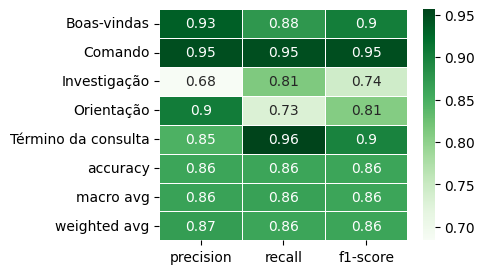

In [97]:
# Plot relatório de classificação
relatorio(y_test_labels, y_pred_labels)

#### **Matriz de confusão**
---

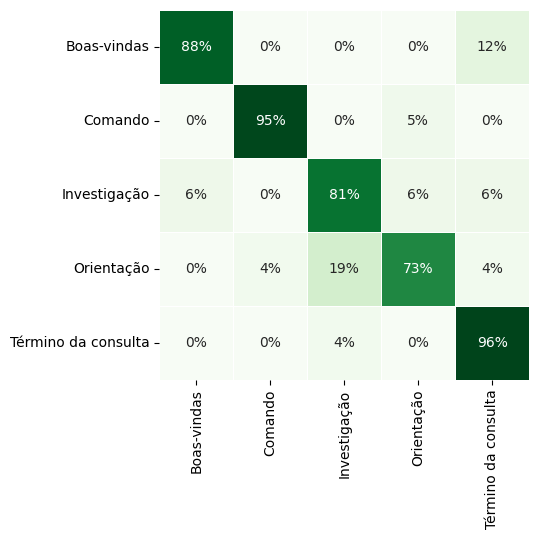

In [98]:
# Plot Matriz de confusão
matriz_confusao(y_test_labels, y_pred_labels)

#### **Resumo**
---

Conclusões após avaliação:
- Acurácia = 86%
- ROC_AUC = 91%
- F1-Score (média ponderada) ficou em 86%

Resumidamente, tivemos uma perda nos resultados de teste em comparação ao nosso primeiro modelo GRU. Perdemos acurácia em todas as classificações. Através da matriz de confusão conseguimos notar que 'Orientação' é a classe com menor taxa de acerto (73%) e acabou rolando algumas confusões com sentimento 'Investigação' (19%) e 'Comando' (4%).

### **Avaliação 2 | Dados de validação**
---

Agora que temos um novo modelo, podemos avaliar novamente nossos dados de validação:

#### **Preparação dos dados**
---

In [99]:
# Importando os dados
df_val = pd.read_csv("Dados_validacao_comandos.csv")

# Removendo stopwords
df_val["Texto"] = df_val.Texto.apply(remove_stopwords).astype(str)

# Limpeza e tratamento de dados
df_val["Texto"] = df_val.Texto.apply(tratar_texto).astype(str)

# pré-processamento necessário nos dados de validação
X_val = df_val['Texto'].values
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post')

# Previsões no dataset de validação
previsoes = model2.predict(X_val_pad)

# previsões de volta para as classes originais
classes_previsoes = label_encoder.inverse_transform(np.argmax(previsoes, axis=1))

4/4 [==============================] - 0s 9ms/step


#### **Acurácia**
---

In [103]:
# Calcule as métricas desejadas
acuracia = accuracy_score(df_val['Classificacao'], classes_previsoes)
# Imprima as métricas
print("Acurácia do modelo = %2.f%%" % (acuracia *100.00))

Acurácia do modelo = 72%


#### **Download CSV - Previsões**
---

In [101]:
# Coluna de previsões ao DataFrame df_val
df_val['Previsoes'] = classes_previsoes

# Adicione a coluna 'Resultado' com base nas condições
df_val['Resultado'] = ['Ok' if s == p else 'Verificar'
                             for s, p in zip(df_val['Classificacao'], df_val['Previsoes'])]

In [ ]:
# Download das previsões
df_val.to_csv('PrevisoesModeloGRU_LSTM_v1_1.csv', index=False)

In [102]:
# Quais sentimentos tivemos mais erros
count_verificar = df_val[df_val['Resultado'] == 'Verificar'].groupby('Classificacao').size()
count_verificar

Classificacao
Boas-vindas            6
Comando                4
Investigação           6
Orientação             7
Término da consulta    5
dtype: int64

#### **Resumo**
---

Conclusões após avaliação:
- Ainda tivemos uma acurácia ruim de 72% no dados de validação, porém o modelo v1.1 apresentou uma acurácia 8% maior que o modelo inicial.

- Acredito que desta vez não tivemos um overfiting, pois aplicamos técnicas de regularização e dropout 'agressivo'. O que pode estar afetando a assertividade é a quantidade de dados ou a qualidade desses dados, vale uma revisão.

- Top 3 sentimentos que mais errou:
  - 1º Orientação
  - 2º Investigação
  - 3º Boas-vindas


## **Conclusão**
---

Através deste estudo, quis trazer a criação de um modelo de machine learning, passando por processos de tratamentos de dados, modelagem, otimização, avaliação e por fim a submissão do nosso modelo em dados de teste, a fim de deixar o entendimento mais transparente e direto.

Obviamente, como todos os estudos, este não é uma exceção e poderá ser sempre refinado e sempre estará aberto para novas ideias, feedbacks e ferramentas a serem implementadas.

Nessa etapa testamos mais um algoritmo para nosso sistema de classificação de texto do usuário. Fizemos 2 versões com uma arquitetura de redes neurais chamada GRU e LSTM (v1.0; v1.1) e testamos diversas configurações/modificações possíveis no modelo.

Resumindo cada versão e resultados em tópicos temos o seguinte:

**v1.0**
- Camada GRU
- Acurácia = 92%
- ROC_AUC = 95%
- F1-score = 92%
- Acurácia de validação = 64%

**v1.1**
- Camada GRU + LSTM + Atenção
- Acurácia = 86%
- ROC_AUC = 91%
- F1-score = 86%
- Acurácia de validação = 72%